start position start with 0, so the end position is the right position. 

a: m6Aの修飾の有無

m: m5Cの修飾の有無

21839: m4Cの修飾の有無

"+" is positive strand

"-" is negative strand!! G→C, T→A

9列目：合計のCの数

11列目が1の場合：変異している modified

12列目が1の場合：変異していない canonical

13列目が1の場合:other

1. Download scp namuka@matsu:/mnt/hdd/namuka/GridION/bam/r0036m.GRCm39.bam ~/Desktop/
2. samtools merge methyl.bam r0031m.GRCm39.v2.bam r0036m.GRCm39.bam
3. modkit pileup methyl.bam output.bed --log-filepath methyl.log

In [1]:
import csv
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
chromosome_mapping = {
    'NC_000067.7': 1, 'NC_000068.8': 2, 'NC_000069.7': 3, 'NC_000070.7': 4,
    'NC_000071.7': 5, 'NC_000072.7': 6, 'NC_000073.7': 7, 'NC_000074.7': 8,
    'NC_000075.7': 9, 'NC_000076.7': 10, 'NC_000077.7': 11, 'NC_000078.7': 12,
    'NC_000079.7': 13, 'NC_000080.7': 14, 'NC_000081.7': 15, 'NC_000082.7': 16,
    'NC_000083.7': 17, 'NC_000084.7': 18, 'NC_000085.7': 19, 'NC_000086.8': 'X',
    'NC_000087.8': 'Y'
}

In [7]:
control_hippo= pd.read_csv('../../data/1.0.0/01_preprocessed/gene_methylations/bdnf_hippocampus_control.csv')
thyroid_hippo = pd.read_csv('../../data/1.0.0/01_preprocessed/gene_methylations/bdnf_hippocampus_thyroid.csv')

exon = pd.read_csv('../../data/reference/gene_regions/bdnf_exon.csv')
cds = pd.read_csv('../../data/reference/gene_regions/bdnf_cds.csv')

file_path = "../../data/reference/gene_regions/bdnf_region_info.txt"

with open(file_path, "r") as f:
    line = f.readline().strip().split("\t")

chromosome, start, end, strand = line
gene_start, gene_end = int(start), int(end)

print(chromosome, gene_start, gene_end, strand)

NC_000068.8 109505045 109557388 +


In [18]:
exon

,start,end
0,109505045,109505684
1,109506242,109506823
2,109507377,109507569
3,109522781,109523119
4,109523372,109523452
5,109523908,109524254
6,109524754,109524966
7,109539728,109540006
8,109553266,109557388


In [12]:
control_hippo.columns

Index(['chrom', 'start', 'end', 'type', 'strand', 'all', 'ratio', 'mod',
       'canonical', 'next_base'],
      dtype='object')

In [8]:
control_hippo.head()

,chrom,start,end,type,strand,all,ratio,mod,canonical,next_base
0,NC_000068.8,109505045,109505046,a,+,2,0.0,0,2,NaN
1,NC_000068.8,109505046,109505047,a,+,2,0.0,0,2,NaN
2,NC_000068.8,109505047,109505048,a,+,2,0.0,0,2,NaN
3,NC_000068.8,109505049,109505050,m,+,2,0.0,0,2,A
4,NC_000068.8,109505049,109505050,21839,+,2,0.0,0,2,NaN


In [41]:
print(control_hippo['ratio'].max())

100.0


In [9]:
methylation_types = [
    ('df_cg', 'm5C in CpG', 'red'),
    ('df_non_cg', 'm5C in non CpG', 'purple'),
    ('df_4', 'm4C', 'orange'),
    ('df_a', 'm6A', 'green')
]

def get_smoothed_and_df(df, type_filter):
    # type_filterは 'm', '4', 'a' など
    if type_filter == 'm':
        df_cg = df[(df['type'] == 'm') & (df['next_base'] == 'G')]
        df_non_cg = df[(df['type'] == 'm') & (df['next_base'] != 'G')]
        return (df_cg, df_non_cg)
    elif type_filter == '4':
        df_4 = df[df['type'] == '4']
        return (df_4,)
    elif type_filter == 'a' or type_filter == '21839':
        df_a = df[df['type'].isin(['a', '21839'])]
        return (df_a,)

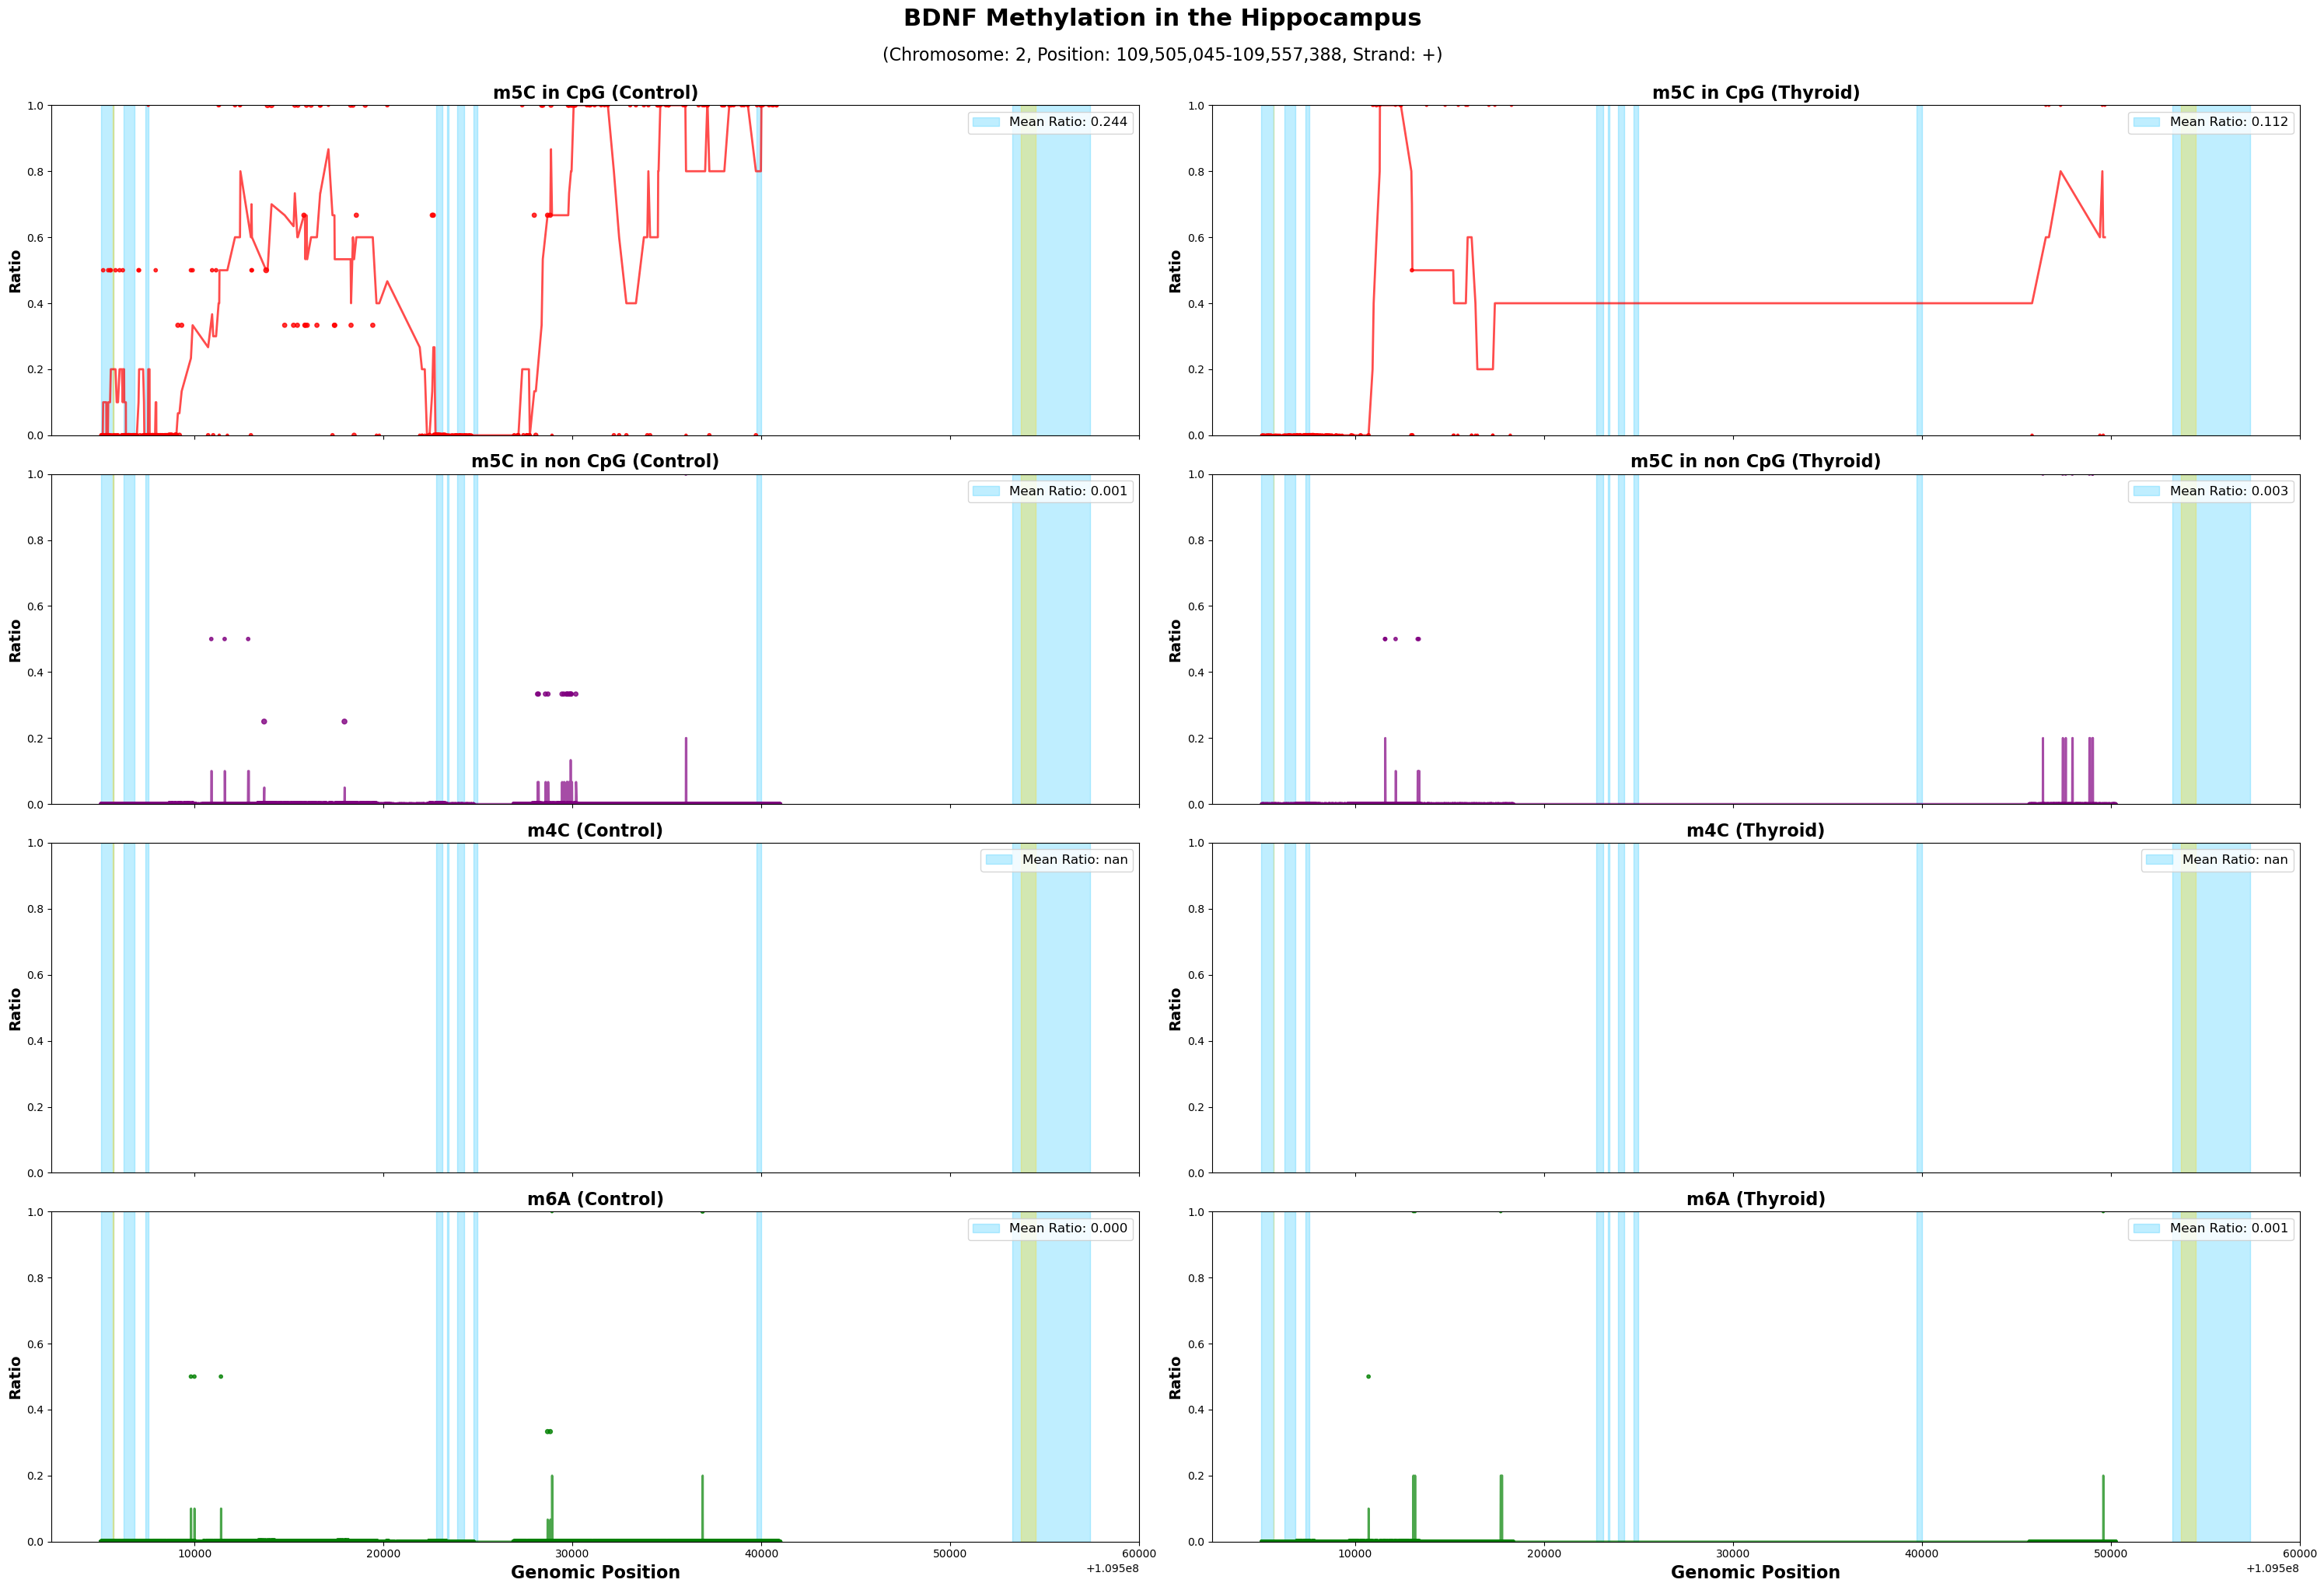

In [ ]:
chr_display = chromosome_mapping.get(chromosome, chromosome)


fig, axes = plt.subplots(len(methylation_types), 2, figsize=(30, 20), sharex=True)

for i, (key, title, color) in enumerate(methylation_types):
    # === データ抽出 ===
    if key == 'df_cg':
        ctrl_data = control_hippo[(control_hippo['type'] == 'm') & (control_hippo['next_base'] == 'G')]
        thy_data  = thyroid_hippo[(thyroid_hippo['type'] == 'm') & (thyroid_hippo['next_base'] == 'G')]
    elif key == 'df_non_cg':
        ctrl_data = control_hippo[(control_hippo['type'] == 'm') & (control_hippo['next_base'] != 'G')]
        thy_data  = thyroid_hippo[(thyroid_hippo['type'] == 'm') & (thyroid_hippo['next_base'] != 'G')]
    elif key == 'df_4':
        ctrl_data = control_hippo[control_hippo['type'] == '4']
        thy_data  = thyroid_hippo[thyroid_hippo['type'] == '4']
    elif key == 'df_a':
        ctrl_data = control_hippo[control_hippo['type'].isin(['a', '21839'])]
        thy_data  = thyroid_hippo[thyroid_hippo['type'].isin(['a', '21839'])]

    # === 正規化 ===
    ctrl_data = ctrl_data.copy()
    thy_data = thy_data.copy()
    ctrl_data['ratio'] = ctrl_data['ratio'] / 100
    thy_data['ratio'] = thy_data['ratio'] / 100

    # === 移動平均 ===
    ctrl_smooth = ctrl_data['ratio'].rolling(window=5, min_periods=1).mean()
    thy_smooth  = thy_data['ratio'].rolling(window=5, min_periods=1).mean()

    # === プロット（Control / Thyroid共通設定） ===
    for j, (data, smoothed, tissue, ax) in enumerate([
        (ctrl_data, ctrl_smooth, 'Control', axes[i, 0]),
        (thy_data,  thy_smooth,  'Thyroid', axes[i, 1])
    ]):
        for _, row in exon.iterrows():
            ax.axvspan(row['start'], row['end'], color='deepskyblue', alpha=0.25)
        for _, row in cds.iterrows():
            ax.axvspan(row['start'], row['end'], color='gold', alpha=0.3)

        ax.scatter(data['end'], data['ratio'], s=data['all']*5, color=color, alpha=0.8)
        ax.plot(data['end'], smoothed, color=color, lw=2, alpha=0.7)

        mean_ratio = data['ratio'].mean()
        ax.legend([f"Mean Ratio: {mean_ratio:.3f}"], loc='upper right', fontsize=12)
        ax.set_ylabel('Ratio', fontsize=14, fontweight='bold')
        ax.set_title(f"{title} ({tissue})", fontsize=16, fontweight='bold')

        # === y軸統一 ===
        ax.set_ylim(0, 1)

# === X軸ラベルとタイトル ===
for ax in axes[-1, :]:
    ax.set_xlabel('Genomic Position', fontsize=16, fontweight='bold')

plt.suptitle("BDNF Methylation in the Hippocampus", fontsize=22, fontweight='bold', y=1.02)
fig.text(0.5, 0.995, f"(Chromosome: {chr_display}, Position: {gene_start:,}-{gene_end:,}, Strand: {strand})",
         ha='center', va='top', fontsize=16, fontweight='normal')

plt.tight_layout()
plt.show()

In [11]:
control_pfc= pd.read_csv('../../data/1.0.0/01_preprocessed/gene_methylations/bdnf_pfc_control.csv')
thyroid_pfc = pd.read_csv('../../data/1.0.0/01_preprocessed/gene_methylations/bdnf_pfc_thyroid.csv')

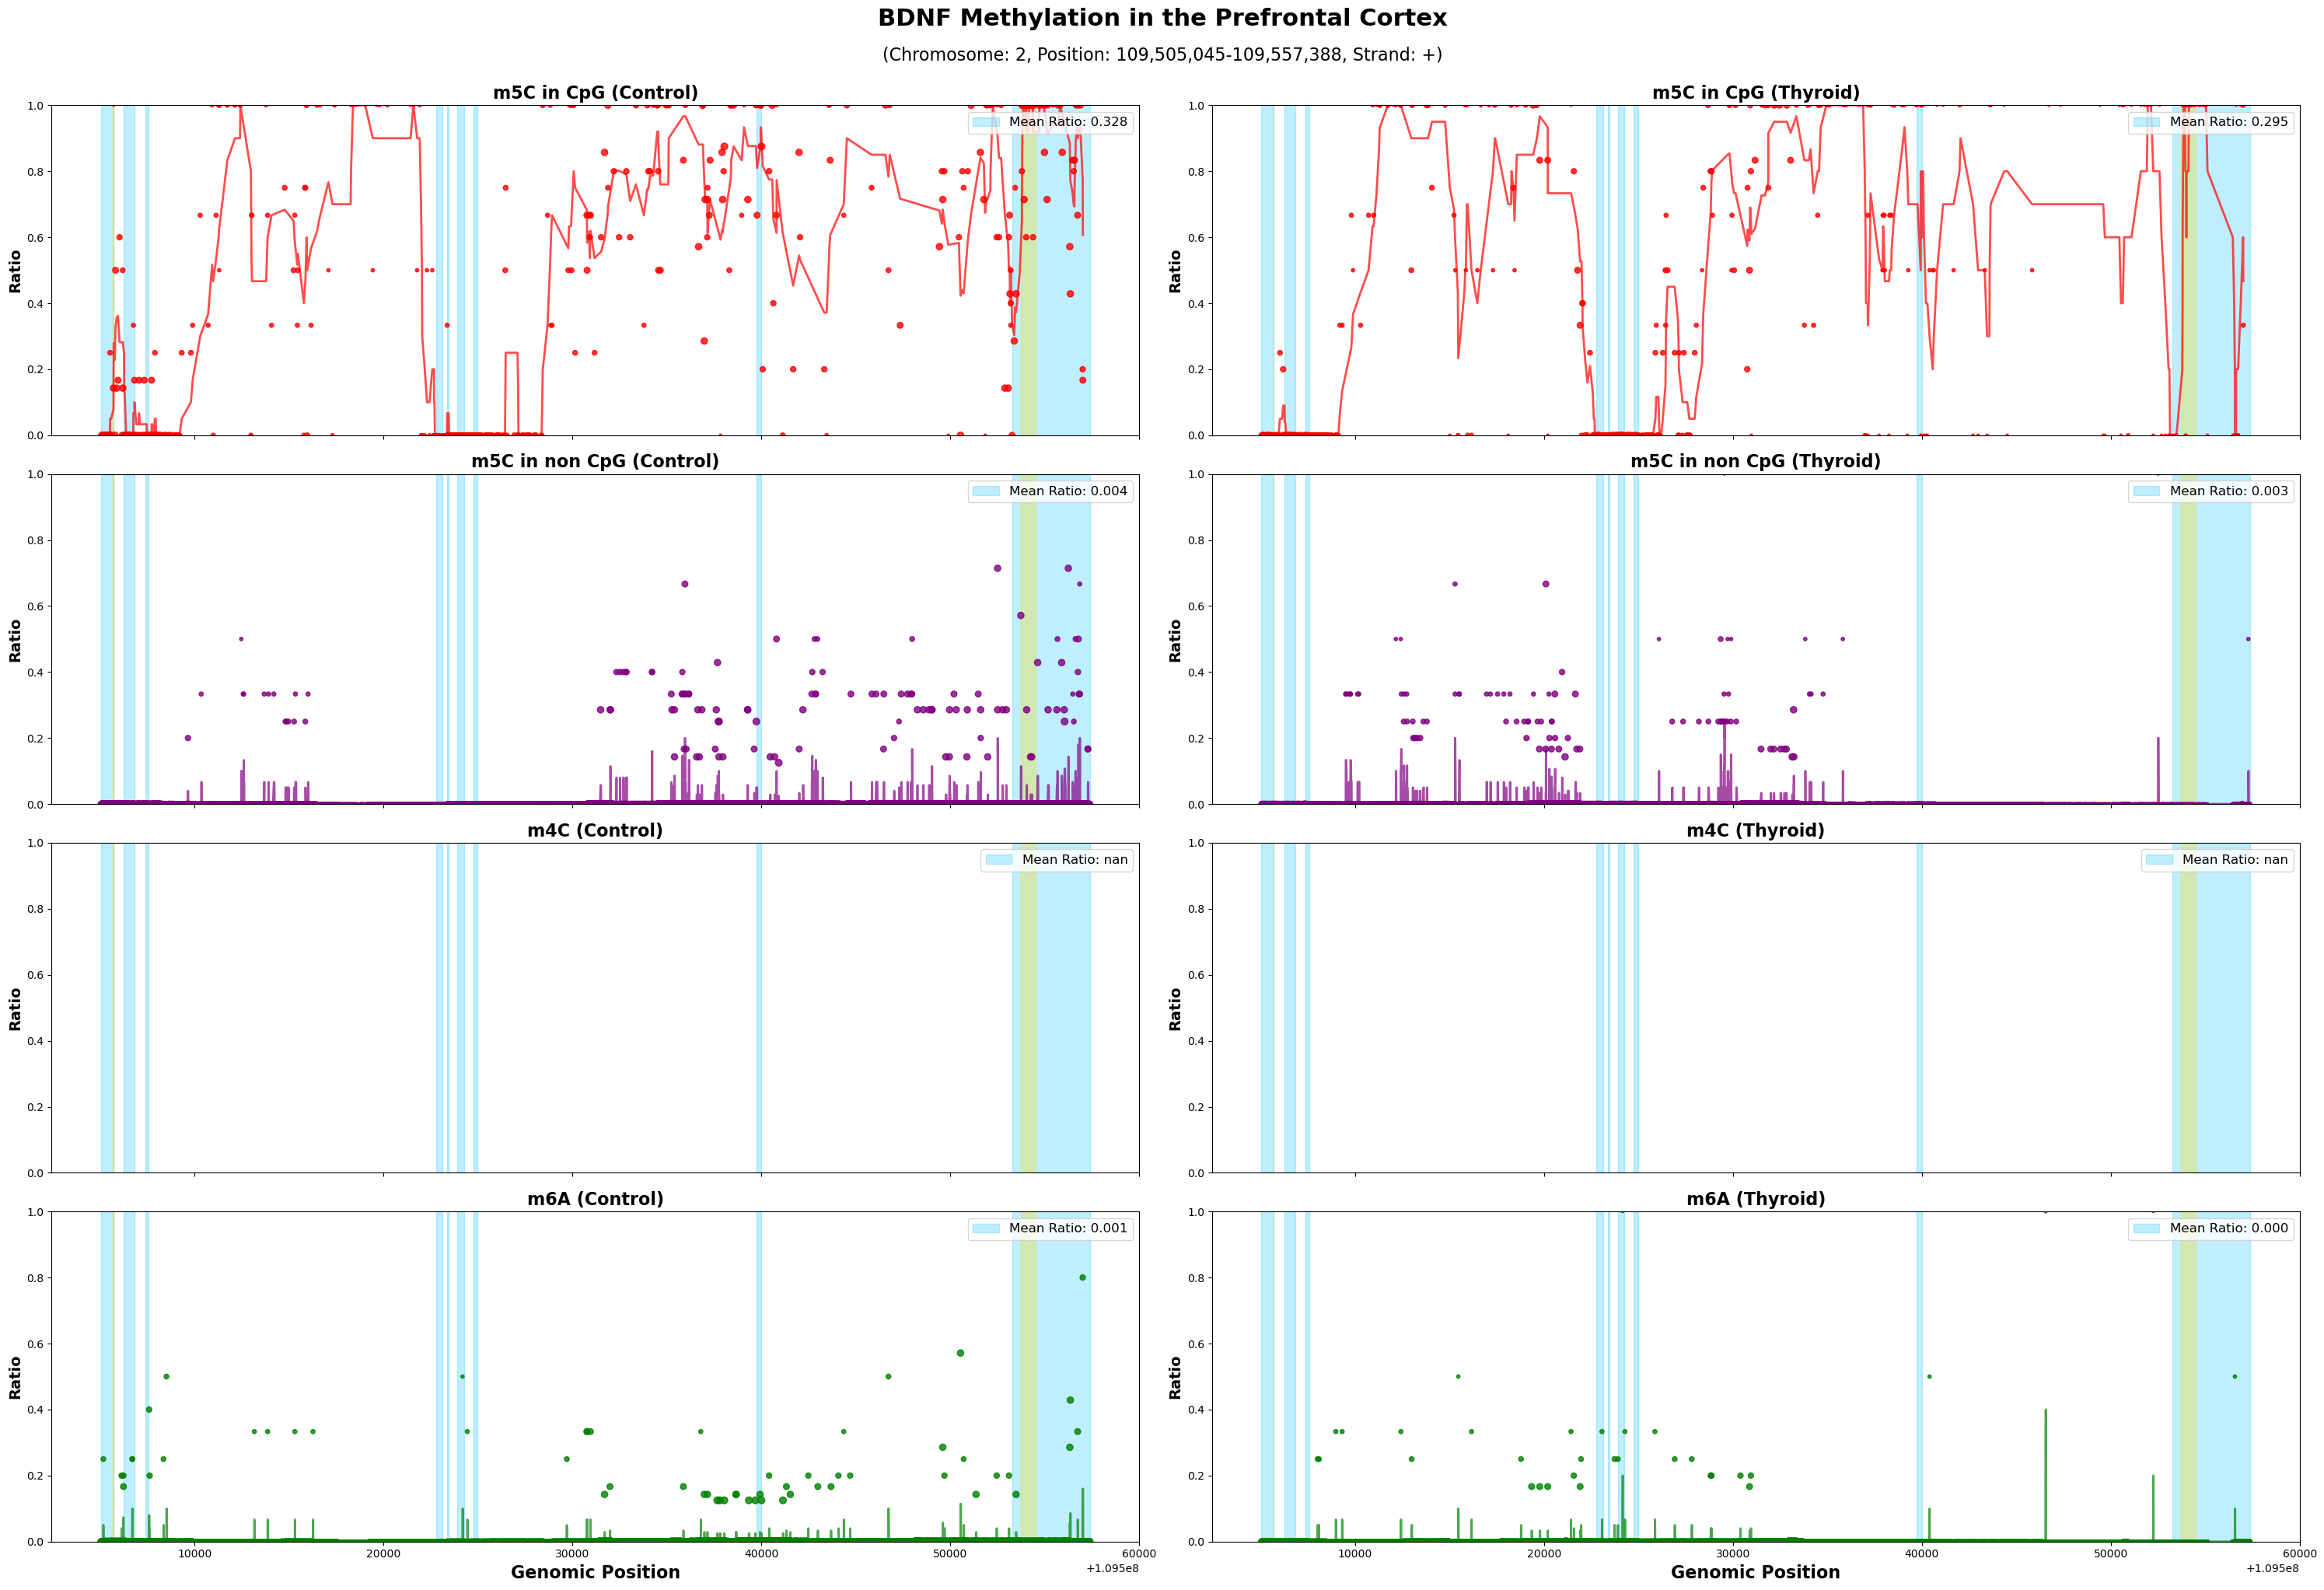

In [10]:
chr_display = chromosome_mapping.get(chromosome, chromosome)


fig, axes = plt.subplots(len(methylation_types), 2, figsize=(30, 20), sharex=True)

for i, (key, title, color) in enumerate(methylation_types):
    # === データ抽出 ===
    if key == 'df_cg':
        ctrl_data = control_pfc[(control_pfc['type'] == 'm') & (control_pfc['next_base'] == 'G')]
        thy_data  = thyroid_pfc[(thyroid_pfc['type'] == 'm') & (thyroid_pfc['next_base'] == 'G')]
    elif key == 'df_non_cg':
        ctrl_data = control_pfc[(control_pfc['type'] == 'm') & (control_pfc['next_base'] != 'G')]
        thy_data  = thyroid_pfc[(thyroid_pfc['type'] == 'm') & (thyroid_pfc['next_base'] != 'G')]
    elif key == 'df_4':
        ctrl_data = control_pfc[control_pfc['type'] == '4']
        thy_data  = thyroid_pfc[thyroid_pfc['type'] == '4']
    elif key == 'df_a':
        ctrl_data = control_pfc[control_pfc['type'].isin(['a', '21839'])]
        thy_data  = thyroid_pfc[thyroid_pfc['type'].isin(['a', '21839'])]

    # === 正規化 ===
    ctrl_data = ctrl_data.copy()
    thy_data = thy_data.copy()
    ctrl_data['ratio'] = ctrl_data['ratio'] / 100
    thy_data['ratio'] = thy_data['ratio'] / 100

    # === 移動平均 ===
    ctrl_smooth = ctrl_data['ratio'].rolling(window=5, min_periods=1).mean()
    thy_smooth  = thy_data['ratio'].rolling(window=5, min_periods=1).mean()

    # === プロット（Control / Thyroid共通設定） ===
    for j, (data, smoothed, tissue, ax) in enumerate([
        (ctrl_data, ctrl_smooth, 'Control', axes[i, 0]),
        (thy_data,  thy_smooth,  'Thyroid', axes[i, 1])
    ]):
        for _, row in exon.iterrows():
            ax.axvspan(row['start'], row['end'], color='deepskyblue', alpha=0.25)
        for _, row in cds.iterrows():
            ax.axvspan(row['start'], row['end'], color='gold', alpha=0.3)

        ax.scatter(data['end'], data['ratio'], s=data['all']*5, color=color, alpha=0.8)
        ax.plot(data['end'], smoothed, color=color, lw=2, alpha=0.7)

        mean_ratio = data['ratio'].mean()
        ax.legend([f"Mean Ratio: {mean_ratio:.3f}"], loc='upper right', fontsize=12)
        ax.set_ylabel('Ratio', fontsize=14, fontweight='bold')
        ax.set_title(f"{title} ({tissue})", fontsize=16, fontweight='bold')

        # === y軸統一 ===
        ax.set_ylim(0, 1)

# === X軸ラベルとタイトル ===
for ax in axes[-1, :]:
    ax.set_xlabel('Genomic Position', fontsize=16, fontweight='bold')

plt.suptitle("BDNF Methylation in the Prefrontal Cortex", fontsize=22, fontweight='bold', y=1.02)
fig.text(0.5, 0.995, f"(Chromosome: {chr_display}, Position: {gene_start:,}-{gene_end:,}, Strand: {strand})",
         ha='center', va='top', fontsize=16, fontweight='normal')

plt.tight_layout()
plt.show()

In [13]:
import pandas as pd
import numpy as np

def extract_cpg(df):
    """CpG sites only"""
    return df[(df['type'] == 'm') & (df['next_base'] == 'G')].copy()

def weighted_methylation(df):
    """DSS-like mean methylation: sum(mod)/sum(all)"""
    if df.empty or df['all'].sum() == 0:
        return np.nan
    return df['mod'].sum() / df['all'].sum()

In [14]:
control_cpg = extract_cpg(control_hippo)
thyroid_cpg = extract_cpg(thyroid_hippo)

gene_level = pd.DataFrame({
    "group": ["control", "thyroid"],
    "mean_methylation": [
        weighted_methylation(control_cpg),
        weighted_methylation(thyroid_cpg)
    ]
})

print(gene_level)

     group  mean_methylation
0  control          0.290196
1  thyroid          0.103448


In [16]:
def region_methylation(df_cpg, regions, region_name="exon"):
    results = []

    for i, row in regions.iterrows():
        start, end = row['start'], row['end']
        sub = df_cpg[(df_cpg['start'] >= start) & (df_cpg['end'] <= end)]

        results.append({
            region_name: i + 1,
            "n_cpg": len(sub),
            "mean_methylation": weighted_methylation(sub)
        })

    return pd.DataFrame(results)
control_exon = region_methylation(control_cpg, exon, "exon")
thyroid_exon = region_methylation(thyroid_cpg, exon, "exon")

control_exon["group"] = "control"
thyroid_exon["group"] = "thyroid"

exon_methylation = pd.concat([control_exon, thyroid_exon])
print(exon_methylation)


   exon  n_cpg  mean_methylation    group
0     1     22            0.1000  control
1     2     30            0.0000  control
2     3      9            0.0625  control
3     4     12            0.0000  control
4     5      3            0.0000  control
5     6     25            0.0000  control
6     7      0               NaN  control
7     8      5            1.0000  control
8     9      0               NaN  control
0     1     22            0.0000  thyroid
1     2     29            0.0000  thyroid
2     3      8            0.0000  thyroid
3     4      0               NaN  thyroid
4     5      0               NaN  thyroid
5     6      0               NaN  thyroid
6     7      0               NaN  thyroid
7     8      0               NaN  thyroid
8     9      0               NaN  thyroid


In [ ]:
control_cds = region_methylation(control_cpg, cds, "cds")
thyroid_cds = region_methylation(thyroid_cpg, cds, "cds")

control_cds["group"] = "control"
thyroid_cds["group"] = "thyroid"

cds_methylation = pd.concat([control_cds, thyroid_cds])
print(cds_methylation)

   cds  n_cpg  mean_methylation    group
0    1      0               NaN  control
1    2      0               NaN  control
0    1      0               NaN  thyroid
1    2      0               NaN  thyroid
